In [ ]:
!pip install llmppl

In [3]:
from llmppl import MambaPPL

mamba = MambaPPL(model_name="state-spaces/mamba-370m-hf")
text = "The quick brown fox jumps over the lazy dog."
ppl = mamba.calculate_ppl(text)
print(f"Perplexity: {ppl}")

Using device: cuda
Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading model...


config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Model loaded successfully: state-spaces/mamba-370m-hf
Perplexity: 5.519785362380925


# Data

In [7]:
AIG = './Dataset/AIGCodeSet.csv'

In [8]:
import pandas as pd

df = pd.read_csv(AIG, usecols=["cleared_code", "label"])
print(df.head())


   label                                       cleared_code
0      1    def get_kth_substring(s, k):\n    substrings...
1      1  from fractions import gcd\ndef create_primeNum...
2      0  import sys\nimport numpy as np\nn, t = map(int...
3      0  import sys\ndef solve(N: int, s: "List[str]"):...
4      1    import string\ndef find_smallest_letter(s):\...


In [13]:
df_llm = df[df["label"] == 1]
df_human = df[df["label"] == 0]

In [18]:

import statistics
from tqdm import tqdm


perpelxity_Human = []
for code in tqdm(df_human['cleared_code'], total=len(df_human)):
    ppl = mamba.calculate_ppl(code)
    perpelxity_Human.append(ppl)
print(statistics.mean(perpelxity_Human))

perpelxity_LLM = []
for code in tqdm(df_llm['cleared_code'], total=len(df_llm)):
    ppl = mamba.calculate_ppl(code)
    perpelxity_LLM.append(ppl)
print(statistics.mean(perpelxity_LLM))





100%|██████████| 249/249 [02:55<00:00,  1.42it/s]


4.763657989067807


100%|██████████| 747/747 [09:33<00:00,  1.30it/s]

4.48540649066465


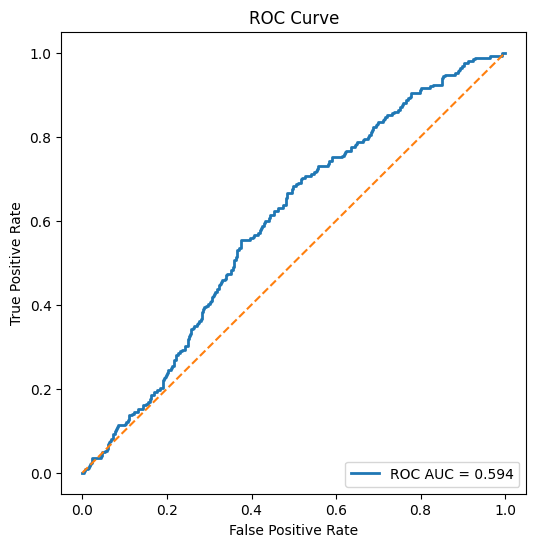

In [19]:
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve


k = -0.26
TP = sum(x > k for x in perpelxity_Human)
FN = sum(x <= k for x in perpelxity_Human)

TN = sum(x <= k for x in perpelxity_LLM)
FP = sum(x > k for x in perpelxity_LLM)


y_true   = [1]*len(perpelxity_Human) + [0]*len(perpelxity_LLM)

y_scores = list(perpelxity_Human) + list(perpelxity_LLM)


fpr, tpr, soglie = roc_curve(y_true, y_scores)   
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()